# Preprocessing

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

In [2]:
train = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/train.csv", encoding='utf-8')
train.set_index("id", inplace=True)

### 1. 위도 경도를 이용해서 지역별로 서귀포, 제주, 고산, 성산으로 4개의 범주를 갖는 지역 변수
### 2. 시간별 강수량은 너무 복잡해지니, 누적 강수량을 구해서 비가 오는 정도에 따른 날씨 변수  
### 3. 날짜별 데이터를 봤을 때 계절변동과 추세가 있는 듯 해보였음 -> 요일 변수와 휴일 변수    
### 4. 버스 노선에 따라서 승객수 차이 남 -> bus_route_id에 따른 범주형 변수 (지역정보랑 겹치지 않을까)

## 1. 지역 변수  

In [67]:
from IPython.display import Image

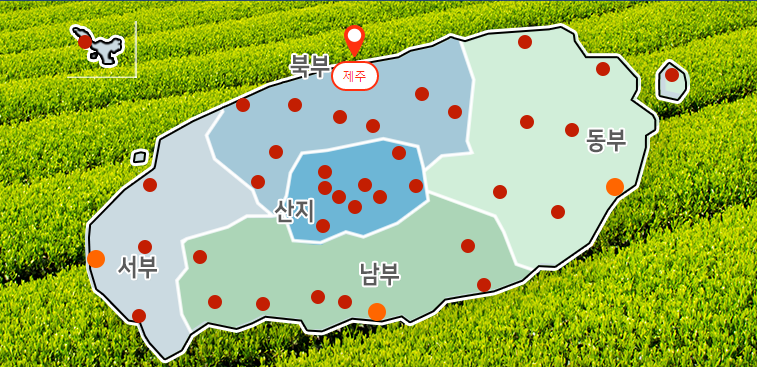

In [69]:
Image("C:/Users/kimch/Desktop/KakaoTalk_20230112_111950318.png")

references: https://www.kma.go.kr/jeju/html/observation/observation_info.jsp

아래 산점도에서도 볼 수 있듯이 산지는 확실히 버스 노선이 없음 -> 승객 수도 적을 듯 함  
서부 / 북부 / 남부 / 동부 / 기타 (산지, 추자도)로 나누고 날씨 데이터는 서부/북부/남부/동부만 하는 걸로?   
추자도/산지 확인해본 결과 승객 수 많지 않음

In [3]:
# 추자도 승객 수
train[train["latitude"]>33.9].describe().iloc[1:,4:]

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
mean,0.008000,0.154667,1.586667,1.586667,1.528000,0.978667,0.0,0.0,0.0,0.0,0.0,0.0,0.493333
std,0.089203,0.596400,4.319132,4.310457,3.878315,2.491606,0.0,0.0,0.0,0.0,0.0,0.0,1.879906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,1.000000,6.000000,41.000000,36.000000,31.000000,21.000000,0.0,0.0,0.0,0.0,0.0,0.0,17.000000


In [4]:
# 산지 승객 수
train[(train["latitude"]>33.32) & (train["latitude"]<33.42) & (train["longitude"]>126.35) & (train["longitude"]<126.725)].describe().iloc[1:,4:]

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
mean,0.080258,0.224477,0.236470,0.201722,0.267220,0.306888,0.162977,0.370849,0.630996,0.584256,0.625461,0.424047,0.524293
std,0.423855,0.732875,1.003095,0.634221,1.018256,0.937894,0.913285,1.577171,2.379110,2.035362,2.180829,1.429599,2.243627
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13.000000,20.000000,22.000000,12.000000,26.000000,15.000000,18.000000,27.000000,40.000000,38.000000,41.000000,30.000000,36.000000


In [4]:
train["longitude"].agg(["min", "max"])

min    126.16504
max    126.96567
Name: longitude, dtype: float64

In [3]:
train["latitude"].agg(["min", "max"])

min    33.20835
max    33.96364
Name: latitude, dtype: float64

In [6]:
min(train["latitude"])

33.20835

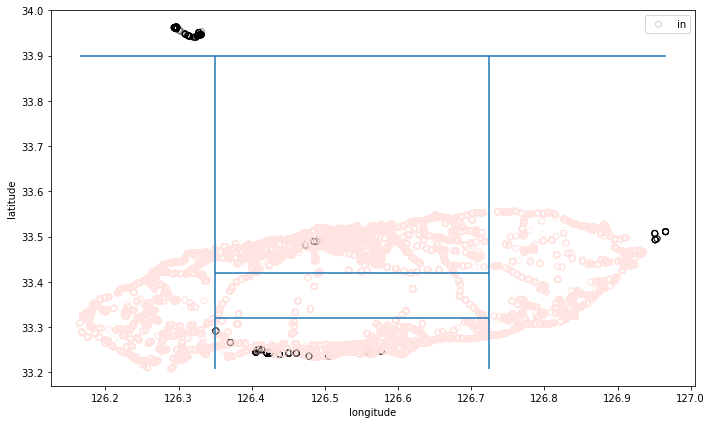

In [43]:
## latitude와 longtitude 산점도로 만들어봄
fig, ax = plt.subplots()
fig.set_size_inches(10,6)

ax.scatter(train.longitude, train.latitude, color=["mistyrose" if c=="시내" else "black" for c in train.in_out], facecolor="none", alpha=0.2)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(["in"])

plt.vlines(126.35, min(train["latitude"]), 33.9)
plt.hlines(33.32, 126.35, 126.725)
plt.vlines(126.725, min(train["latitude"]), 33.9)
plt.hlines(33.42, 126.35, 126.725)
plt.hlines(33.9, min(train["longitude"]), max(train["longitude"]))

plt.tight_layout()
plt.show()

**지역 변수 기준**    
서부(w) : longitude <= 126.35, latitude < 33.5  
남부(s) : 126.35 < longitude < 126.725, latitude < 33.32  
동부(e) : longitude >= 126.75  
북부(n) : 126.35 < longitude < 126.725, latitude > 33.42  
기타(o) : 그 외 (추자도, 산지)  
**서부 : 1 / 남부 : 2 / 동부 : 3 / 북부 : 4 / 기타 : 5**

In [3]:
region_class= []

for i in range (len(train)):
    if ((train["longitude"][i].item() <= 126.35) & (train["latitude"][i].item() < 33.5)):
        region_class.append(1)
    elif ((train["longitude"][i].item() > 126.35) & (train["longitude"][i].item() < 126.725) & (train["latitude"][i].item() < 33.32)):
        region_class.append(2)
    elif ((train["longitude"][i].item() >= 126.75)):
        region_class.append(3)
    elif ((train["longitude"][i].item() > 126.35) & (train["longitude"][i].item() < 126.725) & (train["latitude"][i].item() > 33.42)):
        region_class.append(4)
    else:
        region_class.append(5)

In [4]:
train["region_class"] = region_class

## 2. 날씨 변수

In [5]:
weather_df = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/OBS_ASOS_TIM_20230111115410.csv", encoding='euc-kr')
weather_df

,지점,지점명,일시,강수량(mm),강수량 QC플래그
0,184,제주,2019-09-01 07:00,0.0,NaN
1,184,제주,2019-09-01 08:00,0.0,NaN
2,184,제주,2019-09-01 09:00,0.0,NaN
3,184,제주,2019-09-01 10:00,NaN,9.0
4,184,제주,2019-09-01 11:00,NaN,9.0
...,...,...,...,...,...
1347,189,서귀포,2019-09-30 19:00,2.5,NaN
1348,189,서귀포,2019-09-30 20:00,0.2,NaN
1349,189,서귀포,2019-09-30 21:00,0.0,NaN
1350,189,서귀포,2019-09-30 22:00,1.9,NaN


In [6]:
# 지점이랑 지점명 같은 정보
weather_df["지점명"].unique()

array(['제주', '고산', '성산', '서귀포'], dtype=object)

In [7]:
weather_df["지점"].unique()

array([184, 185, 188, 189], dtype=int64)

In [8]:
# 일단 강수량 컬럼만 NaN값은 0으로 바꿔줌, 일시 datetime format으로 바꿔주기
# weather = weather_df.fillna({'강수량(mm)':0})
weather = weather_df
weather["일시"] = pd.to_datetime(weather.일시, format='%Y-%m-%d %H:%M')

In [9]:
# 지역에 따라 데이터셋 나눠줌
weather_jeju = weather[weather["지점"]==184]
weather_gosan = weather[weather["지점"]==185]
weather_seongsan = weather[weather["지점"]==188]
weather_seoguipo = weather[weather["지점"]==189]

In [10]:
jeju_ts = pd.Series(weather_jeju['강수량(mm)'].values, index=weather_jeju.일시, name="rain_jeju")
gosan_ts = pd.Series(weather_gosan['강수량(mm)'].values, index=weather_gosan.일시, name="rain_gosan")
seongsan_ts = pd.Series(weather_seongsan['강수량(mm)'].values, index=weather_seongsan.일시, name="rain_seongsan")
seoguipo_ts = pd.Series(weather_seoguipo['강수량(mm)'].values, index=weather_seoguipo.일시, name="rain_seoguipo")

In [11]:
weather_jeju["날짜"]= weather_jeju["일시"].dt.date
weather_gosan["날짜"]=weather_gosan["일시"].dt.date
weather_seongsan["날짜"]= weather_seongsan["일시"].dt.date
weather_seoguipo["날짜"]=weather_seoguipo["일시"].dt.date

C:\Users\kimch\AppData\Local\Temp/ipykernel_2760/2138000546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_jeju["날짜"]= weather_jeju["일시"].dt.date
C:\Users\kimch\AppData\Local\Temp/ipykernel_2760/2138000546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_gosan["날짜"]=weather_gosan["일시"].dt.date
C:\Users\kimch\AppData\Local\Temp/ipykernel_2760/2138000546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [12]:
# 날짜랑 강수량만 남김
weather_jeju = weather_jeju[["강수량(mm)", "날짜"]]
weather_gosan = weather_gosan[["강수량(mm)", "날짜"]]
weather_seongsan = weather_seongsan[["강수량(mm)", "날짜"]]
weather_seoguipo = weather_seoguipo[["강수량(mm)", "날짜"]]

In [13]:
# 누적 강수량 구하기
rain_jeju = weather_jeju.groupby('날짜').sum()
rain_gosan = weather_gosan.groupby('날짜').sum()
rain_seongsan = weather_seongsan.groupby('날짜').sum()
rain_seoguipo = weather_seoguipo.groupby('날짜').sum()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47049 missing from curre

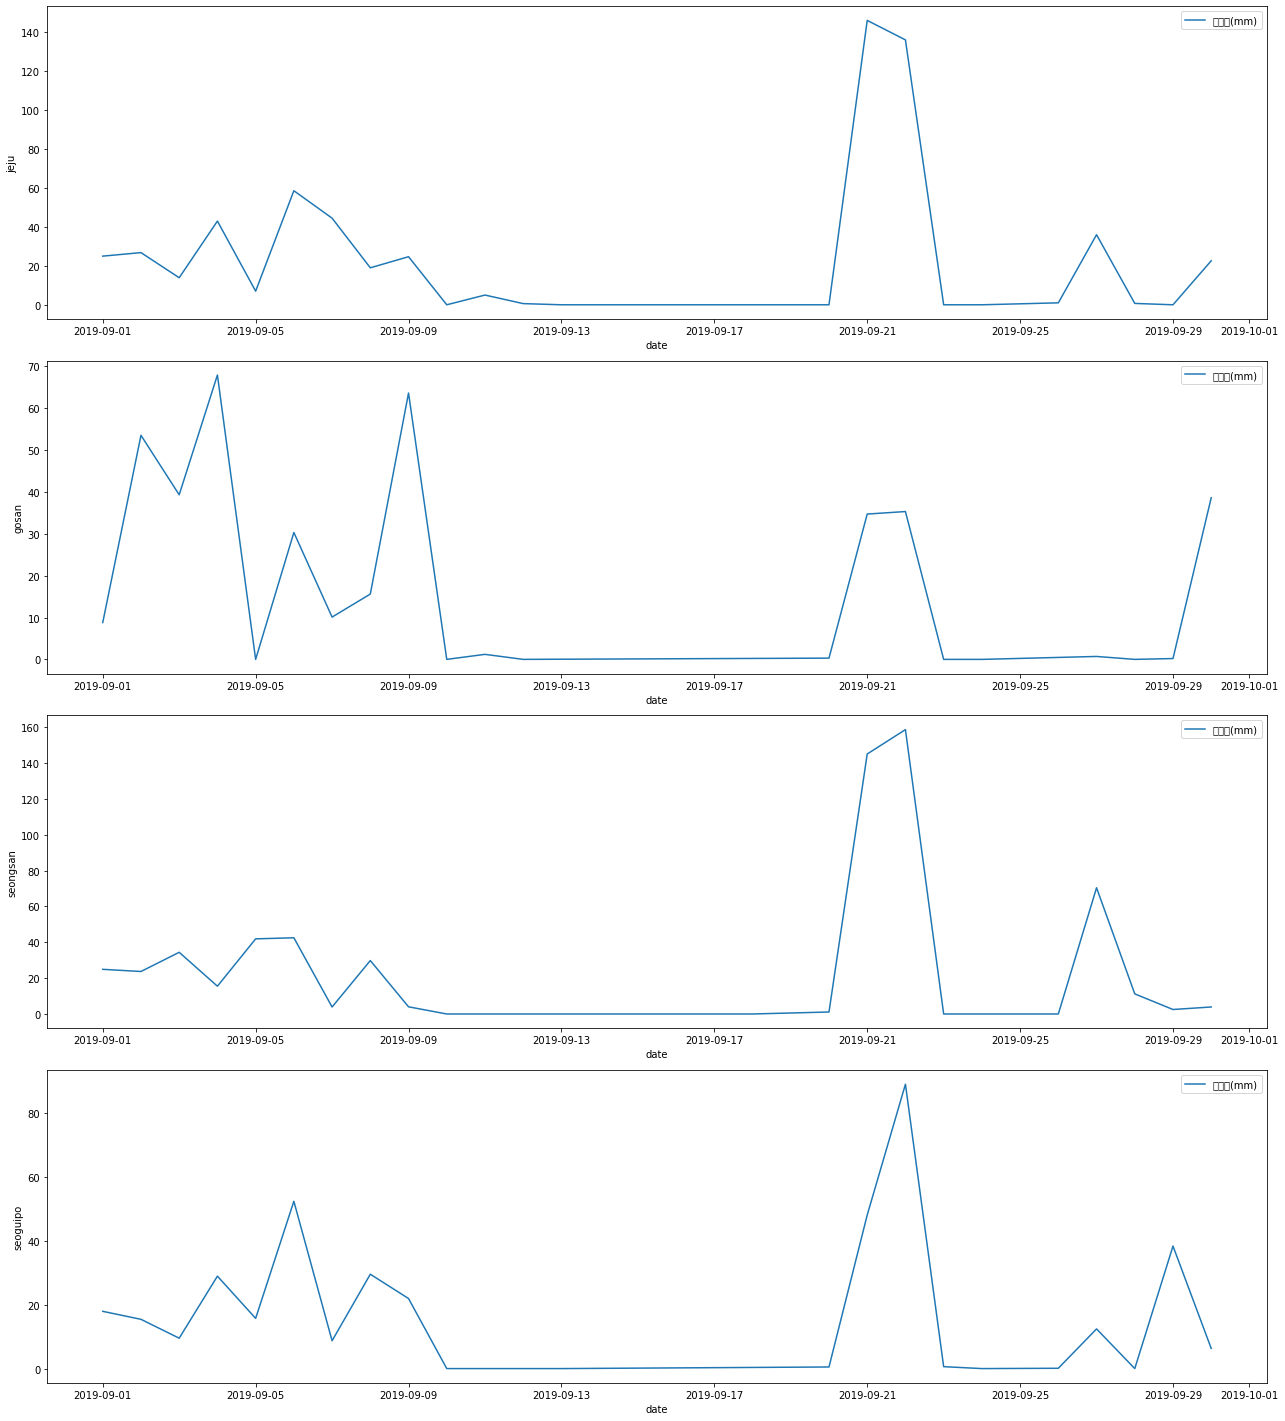

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,20))

rain_jeju.plot(ax=axes[0])
rain_gosan.plot(ax=axes[1])
rain_seongsan.plot(ax=axes[2])
rain_seoguipo.plot(ax=axes[3])

location=["jeju", "gosan", "seongsan", "seoguipo"]
for i in range(4):
    axes[i].set_xlabel('date')
    axes[i].set_ylabel(location[i])
    
plt.suptitle('')
plt.tight_layout()

plt.show()

하루에 17번 관측 (7:00~23:00)  
약한비 : 시간당 ~ 2.5mm  ->  누적 강수량 40mm 이하  -> 0  
보통비 : 시간당 2.5 ~ 7.6mm  ->  누적 강수량 40mm 초과 130mm 이하  -> 1  
폭우: 시간당 7.6mm 이상  -> 누적 강수량 130mm 초과  -> 2

In [12]:
# 근데 결측치도 있는듯 함 -> 결측치 처리해야할듯
print(len(rain_jeju))
print(len(rain_gosan))
print(len(rain_seongsan))
print(len(rain_seoguipo))

25
21
23
22


In [14]:
# 일단 빠진 날짜 사이에 끼워넣어야하는데 도무지 방법이 생각 안나고 계속 에러떠서 노가다 함,,,,,
rain_jeju = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D"),
                          "rain": [25.0, 26.799999999999997, 13.9, 43.0, 7.0, 58.6, 44.5, 19.0, 24.700000000000003, 0.0, 5.0, 0.6, 0.0,
                                   np.nan, np.nan, 0.0, 0.0, np.nan, np.nan, 0.0, 146.1, 136.1, 0.0, 0.0, np.nan, 1.0, 36.0, 0.7, 0.0, 22.6]})

In [15]:
rain_gosan = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D"),
                           "rain": [8.8, 53.5, 39.300000000000004, 67.9, 0.0, 30.3, 10.1, 15.6, 63.6, 0.0, 1.2, 0.0, np.nan, np.nan, 
                                    np.nan, np.nan, np.nan, np.nan, np.nan, 0.3, 34.7, 35.3, 0.0, 0.0, np.nan, np.nan, 0.7, 0.0, 0.2, 38.6]})

In [16]:
rain_seongsan = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D"),
                              "rain": [24.9, 23.7, 34.4, 15.5, 41.9, 42.5, 3.9, 29.799999999999997, 4.0, 0.0, np.nan, np.nan, np.nan,
                                       np.nan, np.nan, 0.0, 0.0, 0.0, np.nan, 1.1, 145.0, 158.6, 0.0, 0.0, np.nan, 0.0, 70.4, 11.2, 2.5, 3.9]})

In [17]:
rain_seoguipo = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D"),
                              "rain": [17.9, 15.4, 9.5, 28.9, 15.700000000000003, 52.3, 8.7, 29.5, 21.900000000000002, np.nan,
                                       0.0, 0.0, 0.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.5, 48.0, 88.9, 0.6, 0.0, np.nan,
                                       0.1, 12.4, 0.0, 38.3, 6.3]})

In [18]:
rain_gosan.reset_index(inplace=True)
rain_seoguipo.reset_index(inplace=True)
rain_seongsan.reset_index(inplace=True)
rain_jeju.reset_index(inplace=True)

In [19]:
rain_gosan["date"] = pd.to_datetime(rain_gosan.date, format="%Y-%m-%d")
rain_seoguipo["date"] = pd.to_datetime(rain_seoguipo.date, format="%Y-%m-%d")
rain_seongsan["date"] = pd.to_datetime(rain_seongsan.date, format="%Y-%m-%d")
rain_jeju["date"] = pd.to_datetime(rain_jeju.date, format="%Y-%m-%d")

In [20]:
rain_gosan = rain_gosan.set_index("date")
rain_seoguipo = rain_seoguipo.set_index("date")
rain_seongsan = rain_seongsan.set_index("date")
rain_jeju = rain_jeju.set_index("date")

In [21]:
# 시계열 데이터이기에 결측치 시계열로 보간하는 interpolate 사용 
rain_gosan_fillna = rain_jeju.interpolate(method="time")
rain_seoguipo_fillna = rain_seoguipo.interpolate(method="time")
rain_seongsan_fillna = rain_seongsan.interpolate(method="time")
rain_jeju_fillna = rain_jeju.interpolate(method="time")

In [23]:
# 결측치 다 보간함
print(rain_gosan_fillna.isna().sum())
print(rain_seoguipo_fillna.isna().sum())
print(rain_seongsan_fillna.isna().sum())
print(rain_jeju_fillna.isna().sum())

index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64
index    0
rain     0
dtype: int64


In [24]:
rain_jeju = rain_jeju_fillna[["rain"]]
rain_gosan = rain_gosan_fillna[["rain"]]
rain_seoguipo = rain_seoguipo_fillna[["rain"]]
rain_seongsan = rain_seongsan_fillna[["rain"]]

In [25]:
rain_class = []

for j in range (30):
    if (rain_jeju.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_jeju.iloc[j].item() > 40) & (rain_jeju.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_jeju.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_jeju["rain_class"] = rain_class

In [26]:
rain_class = []

for j in range (len(rain_gosan)):
    if (rain_gosan.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_gosan.iloc[j].item() > 40) & (rain_gosan.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_gosan.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_gosan["rain_class"] = rain_class

In [27]:
rain_class = []

for j in range (len(rain_seongsan)):
    if (rain_seongsan.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_seongsan.iloc[j].item() > 40) & (rain_seongsan.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_seongsan.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_seongsan["rain_class"] = rain_class

In [28]:
rain_class = []

for j in range (len(rain_seoguipo)):
    if (rain_seoguipo.iloc[j].item() <= 40):
        rain_class.append(1)
    elif ((rain_seoguipo.iloc[j].item() > 40) & (rain_seoguipo.iloc[j].item() <= 130)):
        rain_class.append(2)
    elif (rain_seoguipo.iloc[j].item() > 130):
        rain_class.append(3)
        
rain_seoguipo["rain_class"] = rain_class

In [29]:
# 지역 5 날씨를 어떻게 할 것인지,,, 특히 산지는 그렇다 하고 추자도,,, 
rain_total = pd.DataFrame({"date":list(rain_seoguipo.index.values), 
                           "1:gosan": list(rain_gosan["rain_class"].values),
                           "2:seoguipo": list(rain_seoguipo["rain_class"].values), 
                           "3:seongsan": list(rain_seongsan["rain_class"].values),
                           "4:jeju": list(rain_jeju["rain_class"].values)})
rain_total

,date,1:gosan,2:seoguipo,3:seongsan,4:jeju
0,2019-09-01,1,1,1,1
1,2019-09-02,1,1,1,1
2,2019-09-03,1,1,1,1
3,2019-09-04,2,1,1,2
4,2019-09-05,1,1,2,1
5,2019-09-06,2,2,2,2
6,2019-09-07,2,1,1,2
7,2019-09-08,1,1,1,1
8,2019-09-09,1,1,1,1
9,2019-09-10,1,1,1,1


In [30]:
# 위 데이터셋에서 지역마다 강수량이 크게 차이나고 그러지 않음, 따라서 지역 5의 날씨는 4개 값의 평균을 반올림한 값으로 하겠음
rain_total["5:other"] = [int(round(sum(rain_total.iloc[i][1:])/4,1)) for i in range(30)]
rain_total

,date,1:gosan,2:seoguipo,3:seongsan,4:jeju,5:other
0,2019-09-01,1,1,1,1,1
1,2019-09-02,1,1,1,1,1
2,2019-09-03,1,1,1,1,1
3,2019-09-04,2,1,1,2,1
4,2019-09-05,1,1,2,1,1
5,2019-09-06,2,2,2,2,2
6,2019-09-07,2,1,1,2,1
7,2019-09-08,1,1,1,1,1
8,2019-09-09,1,1,1,1,1
9,2019-09-10,1,1,1,1,1


In [31]:
rain_total["day"] = rain_total["date"].dt.day
rain_total

,date,1:gosan,2:seoguipo,3:seongsan,4:jeju,5:other,day
0,2019-09-01,1,1,1,1,1,1
1,2019-09-02,1,1,1,1,1,2
2,2019-09-03,1,1,1,1,1,3
3,2019-09-04,2,1,1,2,1,4
4,2019-09-05,1,1,2,1,1,5
5,2019-09-06,2,2,2,2,2,6
6,2019-09-07,2,1,1,2,1,7
7,2019-09-08,1,1,1,1,1,8
8,2019-09-09,1,1,1,1,1,9
9,2019-09-10,1,1,1,1,1,10


In [32]:
train["date"] = pd.to_datetime(train.date, format="%Y-%m-%d")
train["day"] = train["date"].dt.day

In [33]:
# train에 날씨 변수 맵핑
weather = []
for i in range (len(train)):
    for j in range (30):
        if train["day"][i] == rain_total["day"][j]:
            weather.append(rain_total.iloc[j,train["region_class"][i]])

In [36]:
train["weather"]= weather
# train = train.drop(columns=["day"])

## 3. 요일/휴일 변수

계절감/추세 있던 것을 확인 -> 요일 변수 생성 (1: 월~7: 일) / 추석연휴 있음 -> 휴일 변수 생성(0: x 휴일, 1: 휴일)  
혹시 너무 과적합되거나 변수 간 상관관계 높으면 나중에 삭제하는걸로

In [18]:
# train["date"] = pd.to_datetime(train.date, format="%Y-%m-%d")
# train["day"] = train["date"].dt.day

In [38]:
# 요일 변수
dayofwk= []

for i in range (len(train)):
    if (train["day"][i] % 7 == 0):
        dayofwk.append(2)
    elif (train["day"][i] % 7 == 1):
        dayofwk.append(3)
    elif (train["day"][i] % 7 == 2):
        dayofwk.append(4)
    elif (train["day"][i] % 7 == 3):
        dayofwk.append(5)
    elif (train["day"][i] % 7 == 4):
        dayofwk.append(6)
    elif (train["day"][i] % 7 == 5):
        dayofwk.append(7)
    elif (train["day"][i] % 7 == 6):
        dayofwk.append(1)
        
train["dayofwk"] = dayofwk

In [39]:
# 휴일 변수
holiday = []

for i in range (len(train)):
    if (train["day"][i] % 7 == 4 or train["day"][i] % 7 == 5 or train["day"][i] == 20 or train["day"][i] == 21 or train["day"][i] == 22):
        holiday.append(1)
    else:
        holiday.append(0)
        
train["holiday"] = holiday

In [40]:
# day 변수는 계산편리 위해 만든 변수였으므로 삭제
train = train.drop(columns=["day"])

## 4. bus_route_id에 따른 범주형 변수

In [41]:
bus_route = pd.pivot_table(train, index="bus_route_id", values=['6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','18~20_ride'], aggfunc="sum")

In [42]:
bus_route

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,18~20_ride,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
bus_route_id,,,,,,,,,,,,,
4270000,997.0,527.0,1049.0,503.0,2409.0,185.0,27.0,943.0,116.0,919.0,328.0,985.0,414.0
4280000,1317.0,650.0,1275.0,734.0,1952.0,634.0,24.0,1104.0,533.0,1495.0,608.0,1260.0,623.0
7990000,18.0,10.0,40.0,35.0,0.0,228.0,163.0,57.0,1.0,64.0,67.0,64.0,37.0
8170000,236.0,153.0,179.0,139.0,1747.0,194.0,73.0,610.0,69.0,458.0,212.0,303.0,200.0
8180000,401.0,312.0,355.0,226.0,566.0,872.0,51.0,662.0,490.0,543.0,333.0,610.0,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32740000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,594.0,141.0,584.0,403.0,59.0,300.0
32760000,0.0,0.0,0.0,0.0,0.0,155.0,22.0,121.0,179.0,0.0,0.0,0.0,2.0
32770000,0.0,0.0,0.0,0.0,0.0,15.0,16.0,1.0,10.0,0.0,0.0,0.0,0.0


In [43]:
bus_route.describe()

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,18~20_ride,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
count,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000
mean,406.353997,276.497553,392.647635,273.022838,841.753670,207.300163,76.491028,562.277325,233.714519,552.553018,350.013051,435.398042,292.030995
std,872.952192,570.328536,879.651749,586.534619,2031.763091,356.254629,149.533693,920.049831,389.252940,1014.561771,606.163005,920.236893,575.659568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,5.000000,5.000000,4.000000,0.000000,0.000000
50%,64.000000,50.000000,53.000000,35.000000,42.000000,45.000000,6.000000,179.000000,82.000000,114.000000,89.000000,66.000000,51.000000
75%,431.000000,309.000000,363.000000,285.000000,710.000000,265.000000,93.000000,704.000000,295.000000,630.000000,437.000000,464.000000,333.000000
max,8571.000000,5153.000000,9323.000000,5801.000000,19734.000000,3358.000000,1224.000000,7432.000000,3499.000000,8177.000000,5022.000000,8038.000000,4845.000000


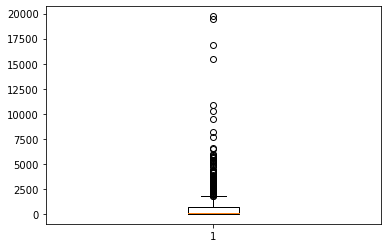

In [44]:
plt.boxplot(bus_route["18~20_ride"])
plt.show()

**bus_route_id에 따른 범주형 변수 기준**  
큰 이상치가 많아서 18~20_ride의 제 3사분위수(=710), 7500 을 기준으로 3 그룹으로 나눔

In [45]:
busroute_class = []
for i in range (613):
    if (bus_route["18~20_ride"].iloc[i]<=710):
        busroute_class.append(1)
    elif ((bus_route["18~20_ride"].iloc[i]>710) & (bus_route["18~20_ride"].iloc[i]<=7500)):
        busroute_class.append(2)
    elif ((bus_route["18~20_ride"].iloc[i] > 7500)):
        busroute_class.append(3)
bus_route["busroute_class"] = busroute_class

In [46]:
bus_route_class = []

for i in range (len(train)):
    if (train["bus_route_id"][i] in list(bus_route[bus_route["busroute_class"]==1].index)):
        bus_route_class.append(1)
    elif (train["bus_route_id"][i] in list(bus_route[bus_route["busroute_class"]==2].index)):
        bus_route_class.append(2)
    elif (train["bus_route_id"][i] in list(bus_route[bus_route["busroute_class"]==3].index)):
        bus_route_class.append(3)
        
train["bus_route_class"] = bus_route_class

## 기타 처리

In [47]:
# 시내/시외 -> 0/1로 값 변경 
train = train.replace("시내", 0)
train = train.replace("시외", 1)

In [48]:
# 범주형 변수 category로 형변환
categorical = ["region_class", "weather", "dayofwk", "holiday", "bus_route_class", "in_out"]
train[categorical] = train[categorical].astype('category')

In [49]:
# 전처리 후 train set -> 총 5개의 변수가 생김
train

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,region_class,weather,dayofwk,holiday,bus_route_class
id,,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,4,1,3,0,2
1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,5.0,4,1,3,0,2
2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4,1,3,0,2
3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,53.0,4,1,3,0,2
4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2,1,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,4,0,1
415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,1,4,0,1
415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,4,0,1


In [50]:
# 위 train 데이터셋들 저장 
train.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre1_train")

In [16]:
# rain_gosan.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/rain_gosan")
# rain_seoguipo.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/rain_seoguipo")
# rain_seongsan.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/rain_seongsan")
# rain_jeju.to_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/rain_jeju")

## train 변수들 간 상관관계 

In [52]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'region_class', 'weather', 'dayofwk', 'holiday',
       'bus_route_class'],
      dtype='object')

In [53]:
# 날씨 변수 제외하고 일단 변수들간 상관관계 히트맵
corr_v = ['in_out', 'station_code', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride',
          '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride', 'region_class', 
          'weather', 'dayofwk', 'holiday', 'bus_route_class']

corr = train[corr_v].corr()

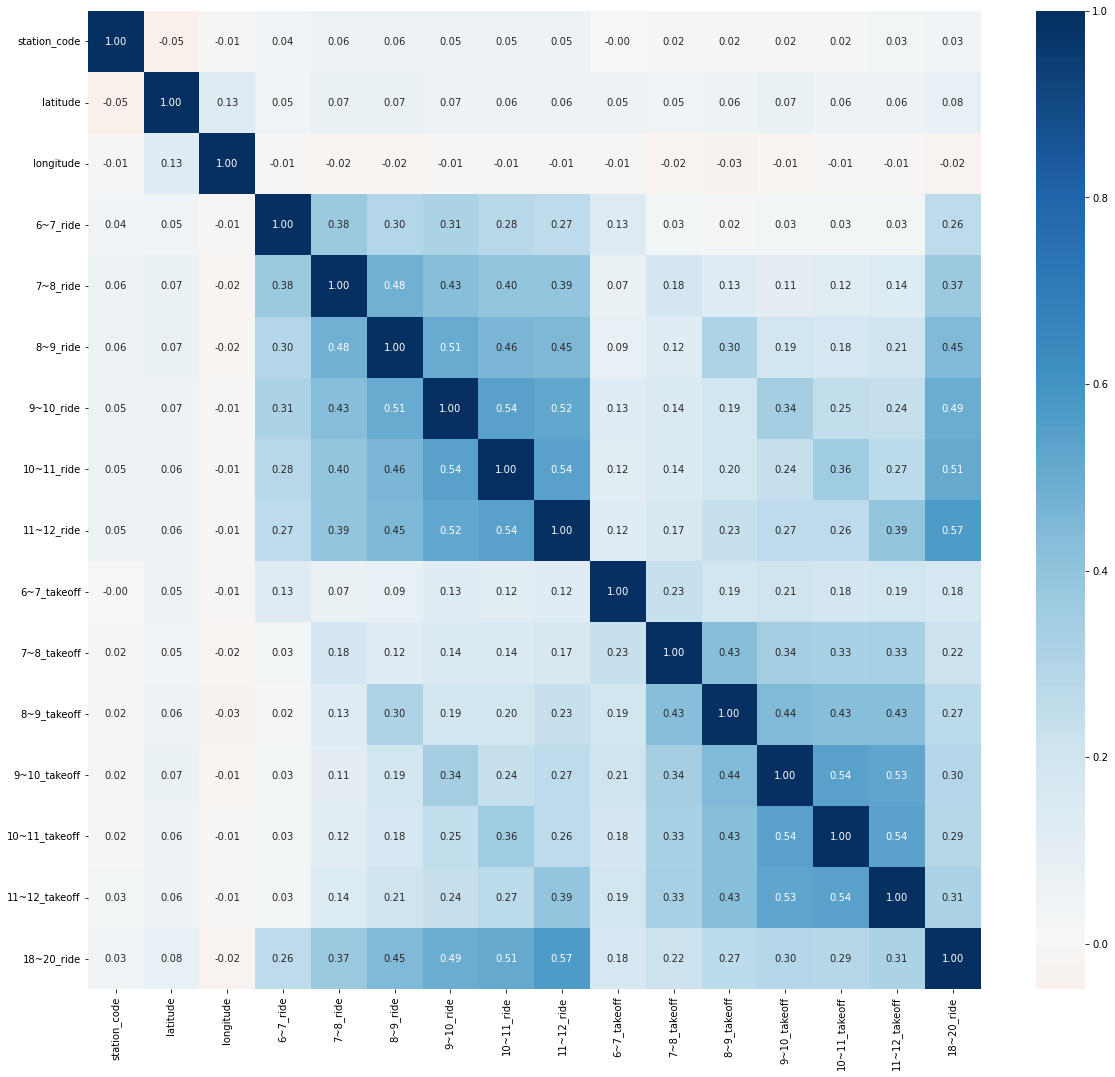

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(20,18)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", center=0, ax=ax)

plt.show()

정류장 상관없이 시간대별 총 승하차 승객수는 매우 높은 상관관계를 보였지만 (특히 9-10_ride, 10-11_ride, 11-12_ride 와 18-20_ride)  
정류장에 따른 데이터일 때는 시간대별 승하차 승객수끼리 높은 상관관계 보이지 않는다.  
또 중복 정보로 보이는 변수들은 없어보인다..

## 날씨 변수와 18~20_ride

<AxesSubplot:xlabel='18~20_ride', ylabel='weather'>

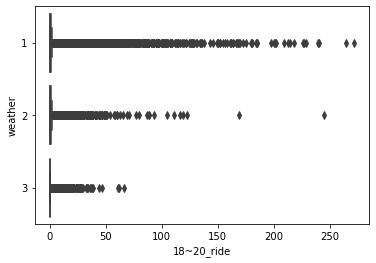

In [58]:
# 날씨 변수를 범주형변수로 만들었기 때문에 상관계수가 안나옴 대신 박스플롯과 범주별 describe로 날씨와 18~20_ride과 관련 있는지
# 음 1,2는 거의 차이 없고, 3이 차이가 많이 나는 듯 흠 그래도 이상치가 확실히 1이 더 크고 3일수록 더 작음
sns.boxplot(y="weather", x="18~20_ride", data=train)

In [60]:
train.groupby(train["weather"])["18~20_ride"].mean()

weather
1    1.289085
2    0.980147
3    0.748103
Name: 18~20_ride, dtype: float64

In [61]:
# 세 그룹 다 18~20_ride 0 값이 많다
train.groupby(train["weather"])["18~20_ride"].median()

weather
1    0.0
2    0.0
3    0.0
Name: 18~20_ride, dtype: float64

In [62]:
train.groupby(train["weather"])["18~20_ride"].max()

weather
1    272.0
2    245.0
3     66.0
Name: 18~20_ride, dtype: float64

**이후 모델 공부하고 돌리기 전까지 해야할 일**  
*1. 결측치 처리 -> 없었음*    
2. bus_bts    
3. Scaling : 수치형 변수 표준화  
4. One-hot-encoding : 범주형 변수  
5. 변수선택 (상관관계, feature selection)
 
**이후 각자 전처리된 데이터셋 간단한 모델에 돌려보고 가장 잘 돌아가는 데이터셋 선택**